# Desafio Spike 

En el siguiente notebook vamos a realizar un análisis para el desafio de Spike.

## 1. Primeros pasos

### 1.1 Librerías

las librerías a utilizar se encuentran en esta sección

In [1]:
import sys
sys.path.append('../datasets')
sys.path.append('../functions')
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

sb.set_style("dark")

### 1.2 Funciones

las Funciones a utilizar se encuentran en esta sección

In [2]:
def descripcion_inicial(x):
    display(x.head())
    display(x.shape)
    print('Valores nulos por variable:')
    display(x.isnull().sum())
    print('valores duplicados por variable:')
    display(x.info())
    display(x.describe().T)
    
def fix_fecha(x):
    try:
        x['mes'] = x.date.apply(lambda y: y.split('-')[1])
        x['año'] = x.date.apply(lambda y: y.split('-')[0])
        x.sort_values(by=['date'], ascending=True, inplace=True)
    except:
        x['mes'] = x.Periodo.apply(lambda y: y.split('-')[1])
        x['año'] = x.Periodo.apply(lambda y: y.split('-')[0])
        x.sort_values(by=['Periodo'], ascending=True, inplace=True)
        x['Periodo'][89] = x['Periodo'][89].replace('13','12')
        #banco_central.Periodo = banco_central.Periodo.dt.date
        
def intervalo_precipitaciones_anual(region, inicio, termino):
    check_region(region)
    check_date(inicio)
    check_date(termino)
    precipitaciones_intervalo = precipitaciones[(precipitaciones['date'] >= inicio) & (precipitaciones['date'] <= termino)][['date', region]]
    precipitaciones_intervalo['mes'] = precipitaciones_intervalo.date.apply(lambda y: y.split('-')[1])
    precipitaciones_intervalo['año'] = precipitaciones_intervalo.date.apply(lambda y: y.split('-')[0])
    precipitaciones_intervalo = precipitaciones_intervalo.rename(columns={region: 'Precipitaciones registradas (mm)'})

    return precipitaciones_intervalo

def check_date(x):
    z = 0
    for y in precipitaciones.date:
        if x == y:
            z = 1
        else:
            pass
    if z == 1:
        print(x + ' se encuentra en el intervalo de fechas')
    else:
        print('La fecha: ' + x + 'no está en el rango de fechas')
        print('inicio periodo: ' + str(precipitaciones.date.min()))
        print('termino periodo: ' + str(precipitaciones.date.max()))
        print('Intenta con otra fecha dentro del rango')
        
def check_region(x):
    if x not in precipitaciones.columns:
        for y in precipitaciones.columns[1:8]:
            print(y)
        x = input('Ingresa el nombre aqui:')
        x = str(x)
        x = x.lower()
        if 'metropolitana' in x:
            x = 'Metropolitana de Santiago'
        elif 'bernardo'in x:
            x = 'Libertador Gral Bernardo O Higgins'
        elif 'ohiggins' in x:
            x = 'Libertador Gral Bernardo O Higgins'
        elif "o'higgins" in x:
            x = 'Libertador Gral Bernardo O Higgins'
        elif 'araucania' or 'araucania' in x:
            x = 'La Araucania'
        elif 'araucanía' in x:
            x = 'La Araucania'
        elif 'rios' or 'ríos' in x:
            x = 'Los Rios'
        elif 'ríos' in x:
            x = 'Los Rios'
        else:
            print('Revisa la función e intenta cambiar la región a una correcta.')
    return x

def precipitaciones_mensuales_df(x):
    region=['Coquimbo', 'Valparaiso', 'Metropolitana de Santiago', 'Libertador Gral  Bernardo O Higgins', 'Maule', 'Biobio', 'La Araucania', 'Los Rios']
    precipitaciones_mensuales = x[region + ['mes']].melt('mes')
    precipitaciones_mensuales = precipitaciones_mensuales.rename({'variable':'Región', 'value':'Precipitaciones registradas'}, axis=1)
    return precipitaciones_mensuales

def precipitaciones_anuales_df(x):
    region=['Coquimbo', 'Valparaiso', 'Metropolitana de Santiago', 'Libertador Gral  Bernardo O Higgins', 'Maule', 'Biobio', 'La Araucania', 'Los Rios']
    precipitaciones_anuales = x[region + ['año']].melt('año')
    precipitaciones_anuales = precipitaciones_anuales.rename({'variable':'Región', 'value':'Precipitaciones registradas'}, axis=1)
    return precipitaciones_anuales

def precipitaciones_anuales_graficos():
    ax = sb.relplot(data = precipitaciones_coquimbo, x= 'año', y= 'Precipitaciones registradas (mm)', kind='line')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    display(ax.fig.suptitle('Precipitaciones anuales en '+region1, fontsize=15, fontdict={"weight": "bold"}))
    ax = sb.relplot(data = precipitaciones_metropolitana, x= 'año', y= 'Precipitaciones registradas (mm)', kind='line')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    display(ax.fig.suptitle('Precipitaciones anuales en '+region2, fontsize=15, fontdict={"weight": "bold"}))
    
def precipitaciones_mensuales_graficos():
    ax = sb.relplot(data = precipitaciones_coquimbo, x= 'mes', y= 'Precipitaciones registradas (mm)', kind='line')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    display(ax.fig.suptitle('Precipitaciones mensuales en '+region1, fontsize=15, fontdict={"weight": "bold"}))
    ax = sb.relplot(data = precipitaciones_metropolitana, x= 'mes', y= 'Precipitaciones registradas (mm)', kind='line')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    display(ax.fig.suptitle('Precipitaciones mensuales en '+region2, fontsize=15, fontdict={"weight": "bold"})) 

def precipitaciones_mensuales_maule():
    lista_años = ['1982','1992','2002','2012','2019']
    precipitaciones_intervalo_años = precipitaciones[precipitaciones['año'].isin(lista_años)]
    precipitaciones_intervalo_años = precipitaciones_intervalo_años[['mes', 'año', 'Maule']]
    precipitaciones_intervalo_años = precipitaciones_intervalo_años.pivot('mes', 'año', 'Maule')
    precipitaciones_intervalo_años = precipitaciones_intervalo_años.rename({'01':'Enero', '02':'Febrero', '03':'Marzo', '04':'Abril', '05':'Mayo', '06':'Junio', '07':'Julio', '08':'Agosto', '09':'Septiembre', '10':'Octubre', '11':'Noviembre', '12':'Diciembre'})
    ax = sb.lineplot(data=precipitaciones_intervalo_años)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

def check_date_pib(x):
    z = 0

    if x in str(banco_central.Periodo):
        print(x + ' se encuentra en el intervalo de fechas')
    else:
        print('inicio periodo: ' + str(banco_central.Periodo.min()))
        print('termino periodo: ' + str(banco_central.Periodo.max()))
        print('Intenta con otra fecha dentro del rango')
def df_series_pib_func(inicio,termino,serie1, serie2):
    banco_central_pib = banco_central[[serie1, serie2, 'mes','año', 'Periodo']]
    df_series_pib = banco_central_pib
    df_series_pib = df_series_pib[(df_series_pib['Periodo'] >= pd.to_datetime(inicio).date()) & (df_series_pib['Periodo'] <= pd.to_datetime(termino).date())][['Periodo', 'PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros']]
    return df_series_pib
def grafico_series_pib(x):
    g = sb.lineplot(x= 'Periodo', y='value', hue='variable', data=pd.melt(df_series_pib, ['Periodo']))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    ylabels = [y for y in g.get_yticks()/1000000]
    g.set_yticklabels(ylabels)
def series_historicas_pib(df,inicio,termino, serie1, serie2):
    df_series_pib = df
    df_series_pib.PIB_Agropecuario_silvicola = df_series_pib.PIB_Agropecuario_silvicola.astype(float)
    df_series_pib.PIB_Servicios_financieros = df_series_pib.PIB_Servicios_financieros.astype(float)
    df_series_pib = df_series_pib.rename({'variable':'value', 'value':'PIB en millones'}, axis=1)
    grafico_series_pib(df_series_pib)    


def mes_numero(x):
    x = x.replace('Ene','01').replace('Feb','02').replace('Mar','03').replace('Abr','04').replace('May','05').replace('Jun','06').replace('Jul','07').replace('Ago','08').replace('Sep','09').replace('Oct',10).replace('Nov','11').replace('Dic','12')
    return x

def precio_leche_df(x):
    x = x.rename({'Anio':'año', 'Mes':'mes'}, axis=1)
    x = mes_numero(x)
    fecha = x['año'].astype(str) +'-'+ x['mes'].astype(str) +'-'+'01'
    x['date'] = pd.to_datetime(fecha).dt.date
    
    x = x.drop(['mes', 'año'], axis=1)
    return x
def trimestres(x):
    a = {'01':'1', '02':'1', '03':'1', '04':'2', '05':'2', '06':'2', '07':'3', '08':'3', '09':'3', '10':'4', '11':'4', '12':'4'}
    x = x.replace(a)
    return x
def combinar_dfs(df1,df2,df3):
    precipitaciones['date'] = pd.to_datetime(precipitaciones['date']).dt.date
    merge_df = pd.merge(df1, df2, on='date')
    try:
        df3 = df3.rename({'Periodo':'date'}, axis=1)
    except:
        pass
    merge_df = pd.merge(merge_df, df3, on='date')
    try:
        merge_df['Trimestre'] = trimestres(merge_df.mes_y)
        merge_df = merge_df.rename({'año_x':'año', 'mes_x':'mes'}, axis=1)
        del merge_df['mes_y']
        del merge_df['año_y']
    except:
        pass
    return merge_df

def fix_df(x):
    x1 = x[['año','mes','Trimestre','date']]
    del x['año']
    del x['mes']
    del x['Trimestre']
    del x['date']
    x = x.apply(pd.to_numeric, errors='coerce')
    x['date'] = x1['date']
    x['año'] = x1['año']
    x['mes'] = x1['mes']
    x['Trimestre'] = x1['Trimestre']
    return x

def subset_variables(x, variab):
    variables = [col for col in variab]
    y = x[['date','año','Trimestre','mes','Precio_leche']]
    x = x.reindex(variables, axis=1)
    x = x[variables]
    z = pd.merge(x, y, on='Precio_leche')
    return z
def analisis_corr():
    corr_df = df.corr()[['Precio_leche']].sort_values(by=['Precio_leche'])
    corr_neg_df = corr_df.head(15)
    corr_pos_df = corr_df.tail(15).sort_values(by=['Precio_leche'], ascending = False)
    trans_df = corr_pos_df[corr_pos_df['Precio_leche'] >= 0.5].T
    variables_final = [col for col in trans_df]
    print('Las variables que cumplen el criterio son:')
    for x in variables_final[1:]:
        print(x)
    print('Muestra del dataframe final:')

    df_final = subset_variables(df,variables_final)
    display(df_final.head(5))
    display(df_final.shape)
    return df_final

def corr_graph():
    corr_df = df.corr()[['Precio_leche']].sort_values(by=['Precio_leche'])
    corr_neg_df = corr_df.head(15)
    corr_pos_df = corr_df.tail(15).sort_values(by=['Precio_leche'], ascending = False)
    x = subset_variables(df,variables_final)
    variables = [col for col in x]
    x = x.reindex(variables, axis=1)
    x = x[variables]
    plot = df_final.corr()
    f, ax = plt.subplots(figsize=(10,10))
    print('Las 15 variables con mayor correlación negativa')
    display(corr_neg_df)
    print('Las 15 variables con mayor correlación Positiva')
    display(corr_pos_df)
    print('Matriz de correlación entre variables seleccionadas')
    sb.heatmap(plot, square=True, annot = True, annot_kws={'size':10}) 
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2:', r2_square)
def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square




### 1.3 Cargando datasets

In [3]:
banco_central = pd.read_csv('datasets/banco_central.csv')
precipitaciones = pd.read_csv('datasets/precipitaciones.csv')



## 2. Análisis de datos

### 2.1 Descripción de los datos 



Los datos se encuentran separados en dos datasets: Precipitaciones y Banco Central que contienen variables climatológicas y macroeconómicas.

Para comenzar a entender los datos, en una primera etapa en esta sección por cada dataset se realizó lo siguiente:
- Mostrar una fracción del dataframe
- Ver cuantas variables y observaciones se tienen
- Revisar si existen valores nulos en las columnas y contarlos
- Ver el tipo de data que es cada variable
- Describir estadisticamente las variables



#### 2.1.1 Precipitaciones


In [4]:
descripcion_inicial(precipitaciones)



,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1989-02-01,0.719033,0.117045,0.028272,0.0,0.724667,9.172945,22.595834,52.268010
1,1998-10-01,0.065216,0.000000,0.011493,0.0,0.008968,2.089674,14.702087,45.142041
2,2001-02-01,2.030026,0.047987,0.002634,0.0,0.032163,10.768351,29.465057,65.571098
3,2008-11-01,0.622784,0.000000,0.015872,0.0,1.734168,25.083557,64.901645,113.093488
4,2009-04-01,0.008065,0.000000,0.009396,0.0,12.080715,56.233424,96.364235,155.622235


(496, 9)

Valores nulos por variable:


date                                   0
Coquimbo                               0
Valparaiso                             0
Metropolitana_de_Santiago              0
Libertador_Gral__Bernardo_O_Higgins    0
Maule                                  0
Biobio                                 0
La_Araucania                           0
Los_Rios                               0
dtype: int64

valores duplicados por variable:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 496 non-null    object 
 1   Coquimbo                             496 non-null    float64
 2   Valparaiso                           496 non-null    float64
 3   Metropolitana_de_Santiago            496 non-null    float64
 4   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64
 5   Maule                                496 non-null    float64
 6   Biobio                               496 non-null    float64
 7   La_Araucania                         496 non-null    float64
 8   Los_Rios                             496 non-null    float64
dtypes: float64(8), object(1)
memory usage: 35.0+ KB


None

,count,mean,std,min,25%,50%,75%,max
Coquimbo,496.0,16.154691,32.629286,0.000000,0.821521,4.071036,16.137600,347.133889
Valparaiso,496.0,32.450980,55.434330,0.000000,1.538162,9.037825,38.409213,441.048604
Metropolitana_de_Santiago,496.0,49.666682,74.361099,0.000000,5.297546,19.087592,63.408364,524.592667
Libertador_Gral__Bernardo_O_Higgins,496.0,72.249805,101.426112,0.000000,5.343992,25.995969,101.875093,645.515752
Maule,496.0,98.662773,122.766771,0.000000,11.897363,45.649888,142.230716,759.177712
Biobio,496.0,128.113406,130.056094,0.001170,29.356684,79.558557,184.751307,702.434707
La_Araucania,496.0,151.486456,126.628503,0.005331,52.930343,110.570990,208.316243,661.211203
Los_Rios,496.0,199.451789,140.073615,0.748127,89.805643,159.467940,274.594590,717.735673


#### Primeras observaciones
A primera vista se puede observar lo siguiente:
- Existen 9 columnas y 496 observaciones.
- No existen valores nulos.
- La fecha es de tipo objecto por lo que se transformará en formato datetime ya que podría presentar problemas en un análisis posterior con el formato actual.
- Al ver el promedio de precipitaciones por región, hace sentido el valor respecto a la posición geográfica, también se puede ver que tanto el mínimo como el máximo son valores dentro de rangos normales de precipitaciones.


#### 2.1.2 Banco central

In [5]:
descripcion_inicial(banco_central)



,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00 UTC,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04-01 00:00:00 UTC,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05-01 00:00:00 UTC,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06-01 00:00:00 UTC,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07-01 00:00:00 UTC,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


(614, 85)

Valores nulos por variable:


Periodo                                              0
Imacec_empalmado                                   314
Imacec_produccion_de_bienes                        314
Imacec_minero                                      314
Imacec_industria                                   313
                                                  ... 
Generacion_de_energia_electrica_CDEC_GWh           350
Indice_de_ventas_comercio_real_IVCM                530
Indice_de_ventas_comercio_real_no_durables_IVCM    530
Indice_de_ventas_comercio_real_durables_IVCM       529
Ventas_autos_nuevos                                469
Length: 85, dtype: int64

valores duplicados por variable:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 85 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Periodo                                                                             614 non-null    object 
 1   Imacec_empalmado                                                                    300 non-null    object 
 2   Imacec_produccion_de_bienes                                                         300 non-null    object 
 3   Imacec_minero                                                                       300 non-null    object 
 4   Imacec_industria                                                                    301 non-null    object 
 5   Imacec_resto_de_bienes                                            

None

,count,mean,std,min,25%,50%,75%,max
Precio_de_la_onza_troy_de_oro_dolaresoz,613.0,578.706574,468.018646,34.9400,292.5400,385.0400,828.8000,1969.780
Precio_de_la_onza_troy_de_plata_dolaresoz,613.0,54.202123,89.493857,1.3200,4.7600,6.0800,35.0800,431.028
Precio_del_diesel_centavos_de_dolargalon,172.0,215.337558,68.625224,79.4900,162.4475,200.3400,286.3925,384.380
Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,253.0,5.055426,8.580500,1.6128,2.8638,3.8851,5.9300,136.338
Precio_del_petroleo_Brent_dolaresbarril,253.0,63.673202,29.704824,18.6000,39.9300,59.3700,79.2700,133.900
Precio_del_petroleo_WTI_dolaresbarril,453.0,43.066137,28.014437,11.3000,20.1000,30.3900,59.8000,133.930
Precio_del_propano_centavos_de_dolargalon_DTN,157.0,88.528822,36.772454,29.2330,54.8880,88.0430,110.7380,187.875
Ventas_autos_nuevos,145.0,26694.082759,7170.231956,4658.0000,23701.0000,27912.0000,31800.0000,39263.000


#### Primeras observaciones
a primera vista se puede observar lo siguiente:
- Existen 85 columnas y 614 observaciones.
- Existen valores nulos.
- Existen bastantes variables con indicadores numéricos como objetos y no como variables numéricas.
- La fecha se presenta en formato UTC.



### 2.2 Limpieza de los datos 

#### 2.1.1 Precipitaciones

Se crean 2 datasets para poder analizar posteriormente consideranto tanto la distribución mensual como anual de las precipitaciones por regiones

In [6]:
fix_fecha(precipitaciones)
precipitaciones.columns = precipitaciones.columns.str.replace('[_]', ' ')
df_mensual = precipitaciones_mensuales_df(precipitaciones)
df_anual = precipitaciones_anuales_df(precipitaciones)


#### 2.1.2 Banco Central

In [7]:
banco_central = banco_central.replace({np.nan: None})
fix_fecha(banco_central)
Periodo = banco_central.Periodo
Periodo = Periodo.replace(' UTC','')

for y in banco_central.columns:
    banco_central[y] = banco_central[y].apply( lambda x: str(x).replace('.',''))
banco_central = banco_central.replace(r'\W', '', regex=True)
banco_central.Periodo = pd.to_datetime(Periodo, format='%Y-%m-%d %H:%M:%S UTC').dt.date

banco_central = banco_central.drop_duplicates(subset=['año', 'mes'])


## 3. Visualizaciones


### 3.1 Graficar series históricas de precipitaciones en intervalos de tiempo determinados

In [8]:
inicio = '2000-01-01'
termino = '2020-01-01'
region1 = 'Coquimbo'
region2 = 'Metropolitana de Santiago'
precipitaciones_coquimbo = intervalo_precipitaciones_anual(region1, inicio, termino)
precipitaciones_metropolitana = intervalo_precipitaciones_anual(region2, inicio, termino)


2000-01-01 se encuentra en el intervalo de fechas
2020-01-01 se encuentra en el intervalo de fechas
2000-01-01 se encuentra en el intervalo de fechas
2020-01-01 se encuentra en el intervalo de fechas


#### 3.1.1 Precipitaciones anuales

Text(0.5, 0.98, 'Precipitaciones anuales en Coquimbo')

Text(0.5, 0.98, 'Precipitaciones anuales en Metropolitana de Santiago')

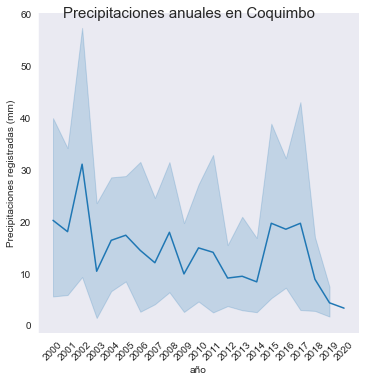

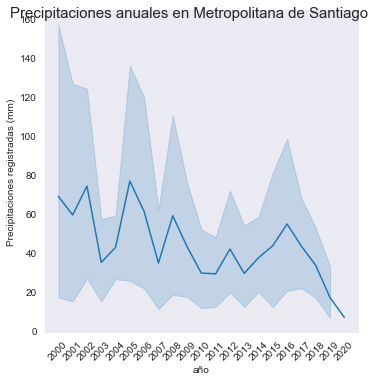

In [9]:
precipitaciones_anuales_graficos()

#### Observaciones Precipitaciones anuales
- En ambas regiones se puede observar que las precipitaciones han tendido a disminuir a lo largo del tiempo, especialmente en los años 2016 y 2017 que los niveles de lluvia son muy bajos.
- En el año 2018 comienzan los niveles más bajos de precipitaciones en ambos casos para el periodo visualizado.
- Hasta el año 2010 se ve que cada 3 años aproximadamente existían los mayores niveles de precipitaciones. 
- Desde el 2016 se ve una caida constante de las precipitaciones.

___Para entender un poco mejor como se comporta la estacionalidad por año, a continuación se pueden ver las precipitaciones por mes.___


#### 3.1.2 Precipitaciones mensuales por año

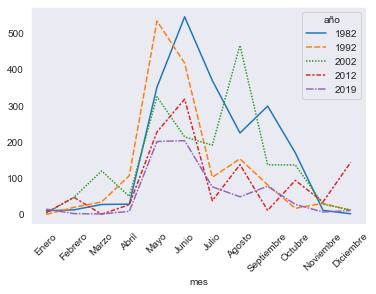

In [10]:
precipitaciones_mensuales_maule()

#### Observaciones Precipitaciones mensuales
- En todos los años, se puede apreciar que los mayores niveles de precipitaciones se registran durante el periodo entre Mayo y Agosto, lo que calza con los meses de invierno en Chile.
- Por otro lado, entre Enero y Abril, además de Noviembre y Diciembre, presentan los niveles más bajos de lluvia(verano).
- Las precipitaciones máximas registradas fueron en Junio de 1982, seguido de Mayo de 1992 y Agosto de 2002, con niveles máximos más bajos en cada periodo.
- Algo que llama la atención es el nivel de precipitaciones registrado el año 2012 en Diciembre, donde se registra el segundo mes con más precipitaciones de ese año, siendo verano. será por el cambio global?


### 3.2 Graficar series historicas del PIB en intervalos de tiempo determinados

El coeficiente de Pearson es: (-0.14617992035267957, 0.1818956892480484)


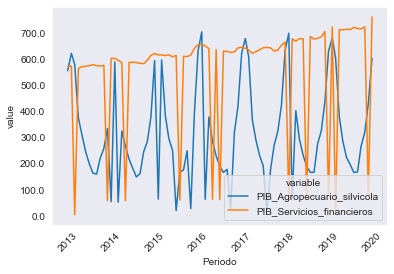

In [11]:
inicio = '2013-01-01'
termino = '2020-01-01'
serie1 = 'PIB_Agropecuario_silvicola'
serie2 = 'PIB_Servicios_financieros'
df_series_pib = df_series_pib_func(inicio,termino,serie1, serie2)
series_historicas_pib(df_series_pib,inicio,termino, serie1, serie2)
print('El coeficiente de Pearson es: '+ str(pearsonr(df_series_pib[serie1], df_series_pib[serie2])))


#### Observaciones del PIB de las series.
- Se ve un incremento de aproximadamente un 15% entre el PIB inicial y el final del sector de Servicios Financieros.
- El sector Agropecuario Silvícola presenta intermitencias dentro de los últimos años, con una decadencia dentro de los últimos 3 años.
- En este, se puede ver que los peaks son en la epoca del verano que a su vez es epoca de cosechas.
- Dado los valores del coeficiente de Pearson, se puede ver que no existe gran correlación entre ambos sectores, lo que hace sentido al pensar que el sector de Servicios Financieros se relaciona con todo tipo de sectores a diferencia del sector Agropecuario Silvícola.


## 4. Tratamiento y creación de variables


### 4.1 Correlación y su impacto en modelos

Existen distintas formas de medir la correlación entre variables, en este caso al tratarse de 2 variables conviene determinar el coeficiente de Pearson para determinar si tienen una correlación positiva, negativa o se pueden considerar como variables independientes. Para otro tipo de variables cuando se tienen distintos tipos de idstribución y variables, conviene utilizar otros metodos como el coeficiente de correlación de Spearman o el coeficiente de correlación de Cramer que son para casos con más de 2 variables.

Cuando se quiere entrenar un modelo es importante considerar la correlación, ya que se busca buscar una relación negativa o positiva entre variables para así poder predecir data similar a la del entrenamiento.


### 4.2 Creando nuevos Dataframes con precio de la leche y otros indicadores

En esta sección se busca crear nuevos dataframes en base a los previamente analizados para poder hacer una predicción del precio de la leche. 

In [12]:
df = pd.read_csv('datasets/precio_leche.csv')
precio_leche = precio_leche_df(df)

#### 4.2.1 Merge de dataframes

Para poder hacer un análisis para determinar que variables son necesarias para predecir el precio de la leche, primero fue necesario hacer un merge de los 3 datasets.

In [13]:
df = combinar_dfs(precipitaciones, precio_leche, banco_central)
df.head(5)

,date,Coquimbo,Valparaiso,Metropolitana de Santiago,Libertador Gral Bernardo O Higgins,Maule,Biobio,La Araucania,Los Rios,mes,...,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos,Trimestre
0,1979-01-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447,01,...,None,None,None,None,None,None,None,None,None,1
1,1979-02-01,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039,02,...,None,None,None,None,None,None,None,None,None,1
2,1979-03-01,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248,03,...,None,None,None,None,None,None,None,None,None,1
3,1979-04-01,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127,04,...,None,None,None,None,None,None,None,None,None,2
4,1979-05-01,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116,05,...,None,None,None,None,None,None,None,None,None,2


#### 4.2.2 Análisis de correlaciones

Para determinar que variables pueden ayudar a predecir el precio de la leche, se procede a hacer un análisis de correlación del dataframe previamente creado. El criterio para considerar una variable relevante es que cumpla una de las siguientes condiciones:
- __x > 0.5__
- __x < -0.5__

Mientras que el resto de las variables no serán consideradas para el modelo de predicción

#### Observaciones
- Se creó una variable para determinar a que trimestre pertenece cada fecha.
- La mayoría de las variables no tenían una correlación relevante para el estudio.
- No existe ninguna variable que tenga una correlación negativa relevante con el precio de la leche.
- Solo se mantuvieron variables que tienen relacion positiva mayor a 0.65.
- Existen variables que tienen correlaciones muy similares, por lo que en la siguiente sección se va a realizar un análisis más extenso para elegir la variable para predecir el precio de la leche.

___para ver todas las correlaciones positivas, negativas y matriz de correlación correr linea de codigo comentaba abajo___

In [14]:
df = fix_df(df)
corr_df = df.corr()[['Precio_leche']].sort_values(by=['Precio_leche'])
corr_neg_df = corr_df.head(15)
corr_pos_df = corr_df.tail(15).sort_values(by=['Precio_leche'], ascending = False)
trans_df = corr_pos_df[corr_pos_df['Precio_leche'] >= 0.5].T
variables_final = [col for col in trans_df]
print('Las variables que cumplen el criterio son:')
for x in variables_final[1:]:
    print(x)
print('Muestra del dataframe final:')
df_final = subset_variables(df,variables_final)
df_final = df_final.drop_duplicates(subset=['año', 'mes'])
display(df_final.head(5))
df_final.shape

Las variables que cumplen el criterio son:
Precio_del_cobre_refinado_BML_dolareslibra
Precio_de_la_onza_troy_de_plata_dolaresoz
Precio_del_petroleo_WTI_dolaresbarril
Precio_de_la_gasolina_en_EEUU_dolaresm3
Precio_de_la_onza_troy_de_oro_dolaresoz
Muestra del dataframe final:


,Precio_leche,Precio_del_cobre_refinado_BML_dolareslibra,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,date,año,Trimestre,mes
0,3.85,752,626,NaN,13672,22727,1979-01-01,1979,1,01
1,4.58,882,742,NaN,16713,24567,1979-02-01,1979,1,02
2,5.18,93,745,NaN,16671,24205,1979-03-01,1979,1,03
3,6.06,952,749,NaN,19831,23916,1979-04-01,1979,2,04
4,7.25,873,837,NaN,24933,25761,1979-05-01,1979,2,05


(496, 10)

In [15]:
#corr_graph()

## 5. Modelo

En esta sección se busca predecir el precio de la leche dado las variables con mayor correlación.

### 5.1 Regresión Lineal

Dado la naturaleza del dataframe, pocos datos y correlacion relativamente alta, se puede predecir utilizando regresión lineal. Resultados que se pueden ver a continuación


In [16]:
df_pred = df_final.fillna(0)
del df_pred['date']
del df_pred['año']
del df_pred['Trimestre']
del df_pred['mes']
Y = df_final['Precio_leche']
del df_pred['Precio_leche']
X = df_pred

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
X_Check = X[-90:]

In [17]:
LinReg = LinearRegression()
LinReg.fit(X_train,y_train)
pred = LinReg.predict(X_test)
test_pred = LinReg.predict(X_test)
train_pred = LinReg.predict(X_train)
print('Resultados del test set:')
print_evaluate(y_test, test_pred)
print('Resultados del train set:')
print_evaluate(y_train, train_pred)
print('El intercepto es:')
print(LinReg.intercept_)

Resultados del test set:
MAE: 34.82068958130591
MSE: 1599.76994528616
RMSE: 39.99712421270009
R2: 0.7262013133452272
Resultados del train set:
MAE: 35.75658920181683
MSE: 1761.0472581270767
RMSE: 41.96483358869753
R2: 0.68421224267607
El intercepto es:
51.55915751639505


In [18]:
coeff_df = pd.DataFrame(LinReg.coef_*1000000, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Precio_del_cobre_refinado_BML_dolareslibra,0.164007
Precio_de_la_onza_troy_de_plata_dolaresoz,152.972157
Precio_del_petroleo_WTI_dolaresbarril,3052.099999
Precio_de_la_gasolina_en_EEUU_dolaresm3,0.365889
Precio_de_la_onza_troy_de_oro_dolaresoz,267.783063


#### Observaciones Regresión Lineal
- Se puede apreciar que R2 es aceptable, con valores de 0.75 y 0.68 para el train y test set correspondientes.
- Las medidas de error están dentro de los rangos aceptables.
- El coeficiente de de la regresión lineal por variable se puede apreciar en la tabla anterior.( Nota: se hizo una conversión para mostrar que por cada 1.000.000 que cambie en el precio de la leche, esos son los valores que cambiarían los precios)


### 5.2 Random Forest Regressor

Al ver los resultados de la regresión lineal, se puede probar un metodo de Random Forest que permite predecir con mayor precisión en algunos casos, por lo que se procederá a evaluar el modelo con las mismas métricas para poder comparar
con el modelo previo.

In [19]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
conf = rfr.score(X_test, y_test)
print(conf)
rfr.fit(X,Y)
test_pred = rfr.predict(X_test)
train_pred = rfr.predict(X_train)
print('Resultados del test set:')
print_evaluate(y_test, test_pred)
print('Resultados del train set:')
print_evaluate(y_train, train_pred)

0.9636283889642825
Resultados del test set:
MAE: 3.441489932885895
MSE: 30.900949006979616
RMSE: 5.558862204352579
R2: 0.9947113400402182
Resultados del train set:
MAE: 4.016471757925075
MSE: 37.63417886763688
RMSE: 6.134670232998419
R2: 0.9932515082213194


Text(0, 0.5, 'Price')

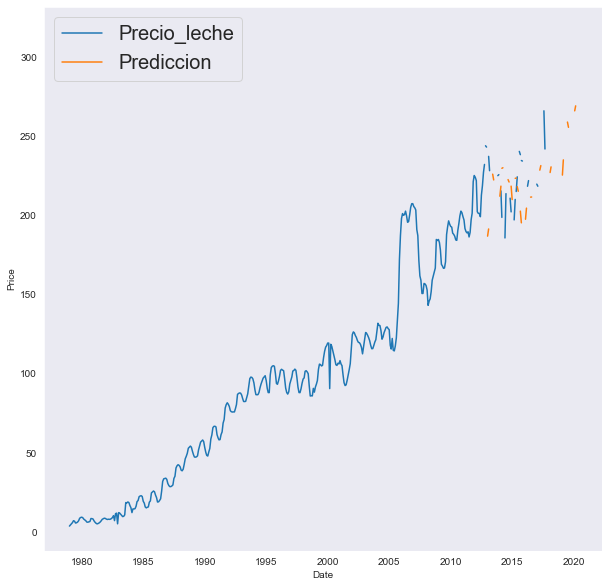

In [20]:
predicciones = rfr.predict(X_Check)
actual = pd.DataFrame(df_final, columns = ['date'])
actual['Precio_leche'] = df['Precio_leche']
actual['Prediccion'] = np.nan
actual.set_index('date', inplace = True)
pred_df = pd.DataFrame(df_final[-90:], columns=['date'])
pred_df['Prediccion'] = predicciones
pred_df.set_index('date', inplace = True)
var = [actual, pred_df]
resultados = pd.concat(var)
resultados.plot(figsize=(10,10))
plt.legend(loc=2, prop={'size':20})
plt.xlabel('Date')
plt.ylabel('Price')

#### Observaciones Random Forest Regressor
- Utilizando Random Forest, el valor de R2 subió considerablemente, dando valores muy cercanos a los reales, esto puede deberse a un overfitting o por que efectivamente se puede predecir el precio de la leche con las variables analizadas.
- Todos los indicadores, bajaron sus valores considerablemente al tener mucha similitud de los datos
- En el gráfico se pueden apreciar los valores reales y predecidos. A simple vista se ve que la predicción continua la tendencia del precio de la leche a lo largo del tiempo.

#### Evaluación del Modelo

Para la evaluación de este modelo, dada sus condiciones se optó por realizar regresiones lineales con 2 métodos diferentes luego de ser separado en 80/20 (train/test). Para ambos se utilizaron las siguientes métricas:

- MAE
- MSE
- RMSE
- R2

El más común de análizar es el último, que mientras más se acerque su valor a 1, significa que los datos predecidos son más parecidos a los datos originales. En este caso se obtuvieron muy buenos valores, pero, esto no necesariamente significa que las variables son las mejores para predecir el valor de la leche, por esto, se incluyó el análisis de las otras 3 medidas de error, que mientras más cercano a 0 este, significa que el error de la predicción es menor. En este caso, los valores no eran tan altos, lo que significa que la predicción fue de una calidad decente.

Luego, se intentó una predicción con un modelo de Random Forest que dió resultados aún mejores, donde R2 subio a casi ser 1 y los otros 3 se acercaron más al 0. 

Para corroborar esto, se graficaron los valores incluyendo las predicciones donde muestra que sigue la tendencia de los precios.

#### Datos Adicionales y Mejoras de Modelo

- Como datos adicionales agregaría más indicadores económicos macro y algunos específicos de la industria a predecir, se podría hacer una investigación de la información disponible en el INE y quizás hacer algún cruce.
- También intentaría tener más observaciones, dado que el número, es relativamente bajo.
- Indicadores por región, dado que la producción de leche es principalmente en una zona específica del país, por lo que es más probable que los precios de insumos y otros afecten más directamente el precio de la leche.
- Indicadores demográficas y medioambientales.
- Probar diferentes metodos para evitar que exista overfitting, dado, que debido al tiempo no alcancé a realizar mayores validaciones.


#### Para que puede servir este modelo y su impacto en el cambio climático

- Al saber como se comportará probablemente el precio de la leche a futuro, se pueden buscar maneras de optimizar la producción y reducir su impacto ambiental.
- Planificación de objetivos y construcción de presupuestos.
- Tomar decisiones estratégicas en base a lo que se predijo y lo que se va cumpliendo, generando una mayor capacidad de reacción.
- Complementar con otros análisis, como el de precipitaciones, para poder mitigar el impacto que tendría el cambio climático con la producción de leche.
- Complementar el proceso de regulación de la industria.
- Ofrecer ayuda oportuna al sector en caso de que haya un impacto grave en donde la producción se vea afectada y con ellos sus resultados.